In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123


In [2]:

df = pd.read_csv(os.path.join("data", "processed", "train.csv"))
df = df.drop(columns=["train"])

df_valid = pd.read_csv(os.path.join("data", "processed", "test.csv"))
df_valid = df_valid.drop(columns=["train", "spaceid", "relativeposition"])


In [3]:

# this drops the amount of datapoints by 95 %
df = df.groupby(
    ["buildingid", "floor", "spaceid", "relativeposition"], as_index=False
).mean()

df.drop(columns=["spaceid", "relativeposition"], inplace=True)


In [4]:

X = df.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y_lon = df.longitude
y_lat = df.latitude
y_floor = df.floor
y = pd.DataFrame({"lon": y_lon, "lat": y_lat, "floor": y_floor})

X_valid = df_valid.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y_valid_lon = df_valid.longitude
y_valid_lat = df_valid.latitude
y_valid_floor = df_valid.floor
y_valid = pd.DataFrame({"lon": y_valid_lon, "lat": y_valid_lat, "floor": y_valid_floor})


In [5]:

X_train, X_test, y_train_lon, y_test_lon = train_test_split(
    X,
    y_lon,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_lat, y_test_lat = train_test_split(
    X,
    y_lat,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

_, _, y_train_floor, y_test_floor = train_test_split(
    X,
    y_floor,
    test_size=0.2,
    random_state=random_state,
    stratify=df[["buildingid", "floor"]],
)

y_train = pd.DataFrame({"lon": y_train_lon, "lat": y_train_lat, "floor": y_train_floor})

y_test = pd.DataFrame({"lon": y_test_lon, "lat": y_test_lat, "floor": y_test_floor})


In [6]:


def calculate_distance(y, y_pred):
    pred_lon = y_pred[:, 0]
    pred_lat = y_pred[:, 1]
    pred_floor = y_pred[:, 2]

    lon_diff2 = (pred_lon - y.lon) ** 2
    lat_diff2 = (pred_lat - y.lat) ** 2
    # lets assume that the height of the floors is 5 meters
    floor_diff2 = ((pred_floor - y.floor) * 5) ** 2

    distance_squared = lon_diff2 + lat_diff2 + floor_diff2

    mean_distance = distance_squared.apply(lambda x: x ** (1 / 2)).mean()

    return mean_distance


distance_scorer = make_scorer(calculate_distance, greater_is_better=False)



In [7]:


def squared_distance(weights):
    # replacing zero values with machine epsilon
    weights[weights == 0] = np.finfo(float).eps
    weights = [
        (1 / weights_obs ** 2) / np.sum(1 / weights_obs ** 2) for weights_obs in weights
    ]
    return weights


param_grid = {
    "n_neighbors": [1, 2, 3],
    "weights": ["uniform", "distance", squared_distance],
    "metric": ["euclidean", "manhattan", "chebyshev"],
}

knn_model = KNeighborsRegressor()

param_search = GridSearchCV(
    knn_model, param_grid, scoring=distance_scorer, n_jobs=-2, cv=100, verbose=2
)

param_search.fit(X_train, y_train)
print("Best Params:")
print(param_search.best_params_)
print("Best CV Score:")
print(-param_search.best_score_)

best_params = param_search.best_params_


Fitting 100 folds for each of 27 candidates, totalling 2700 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-2)]: Done 1607 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-2)]: Done 2661 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-2)]: Done 2687 out of 2700 | elapsed:   49.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 2700 out of 2700 | elapsed:   49.2s finished
/home/tuomo/anaconda3/envs/wifi-locationing/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric

GridSearchCV(cv=100, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-2,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [1, 2, 3],
                         'weights': ['uniform', 'distance',
                                     <function squared_distance at 0x7f262a2b58c8>]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(calculate_distance, greater_is_better=False),
             verbose=2)

In [8]:

knn_model = KNeighborsRegressor(**best_params)
knn_model.fit(X, y)

pred = knn_model.predict(X_valid)

score = calculate_distance(y_valid, pred)

pred_lon = pred[:, 0]
pred_lat = pred[:, 1]
# in case the neighbors is > 1 then we need to make sure that floor is int
pred_floor = np.around(pred[:, 2], decimals=0)

lon_diff2 = (pred_lon - y_valid_lon) ** 2
lat_diff2 = (pred_lat - y_valid_lat) ** 2
# lets assume that the height of the floors is 5 meters
floor_diff2 = ((pred_floor - y_valid_floor) * 5) ** 2

distance_squared = lon_diff2 + lat_diff2 + floor_diff2

distance = distance_squared.apply(lambda x: x ** (1 / 2))

predictions = pd.DataFrame(
    {
        "LATITUDE": pred_lat,
        "LONGITUDE": pred_lon,
        "FLOOR": pred_floor,
        "distance": distance,
    }
)

true_values = pd.DataFrame(
    {
        "LATITUDE": y_valid_lat,
        "LONGITUDE": y_valid_lon,
        "FLOOR": y_valid_floor,
        "distance": distance,
    }
)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights=<function squared_distance at 0x7f262a2b58c8>)

Mean error in meters 10.32026878620009


Text(0.5, 1.0, 'Predictions Floor 0')

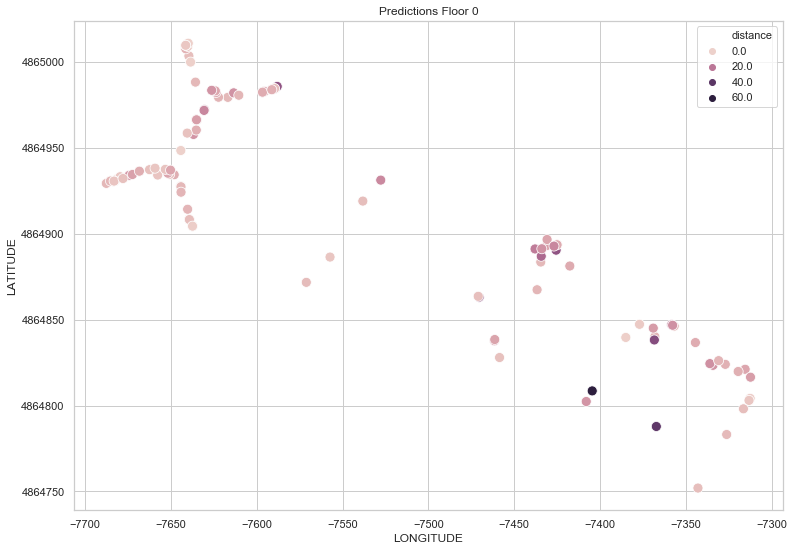

Text(0.5, 1.0, 'Real Values Floor 0')

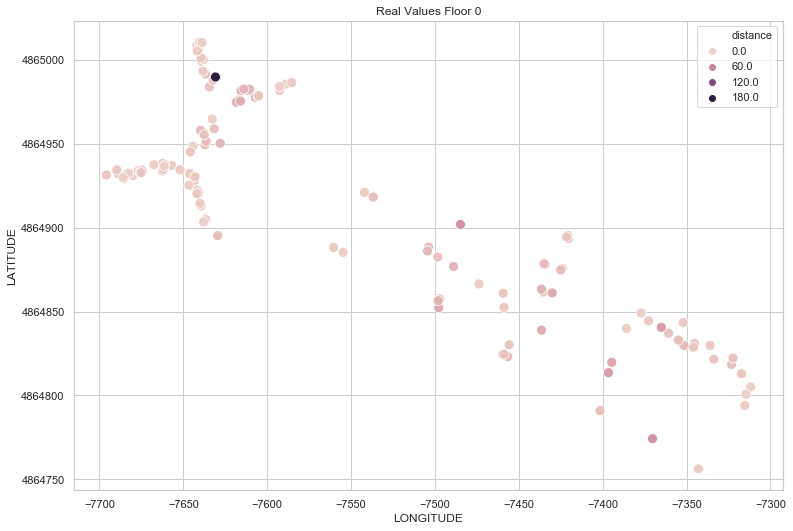

Text(0.5, 1.0, 'Predictions Floor 1')

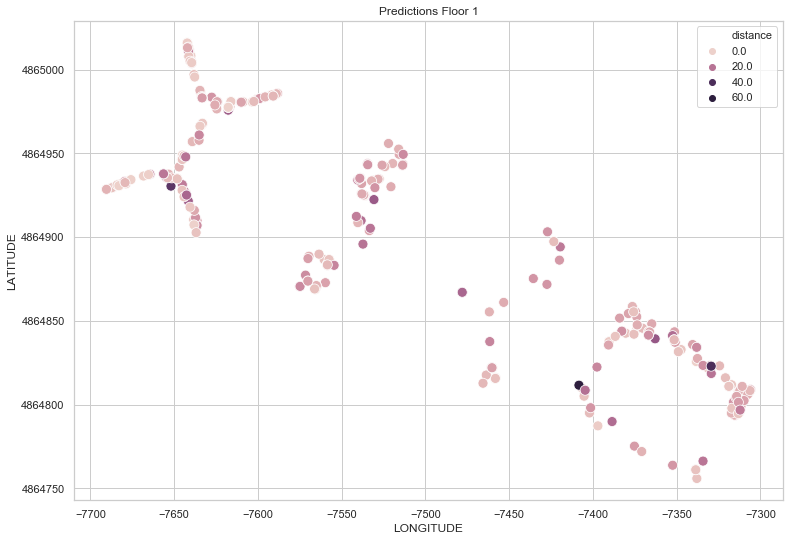

Text(0.5, 1.0, 'Real Values Floor 1')

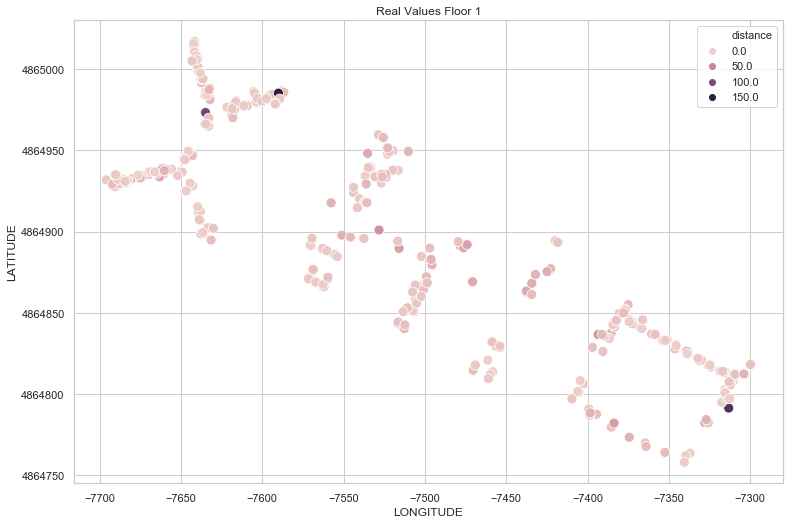

Text(0.5, 1.0, 'Predictions Floor 2')

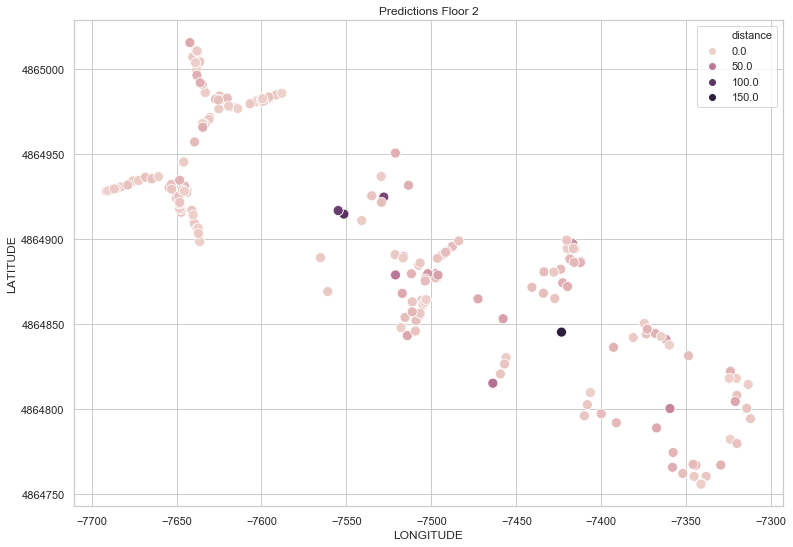

Text(0.5, 1.0, 'Real Values Floor 2')

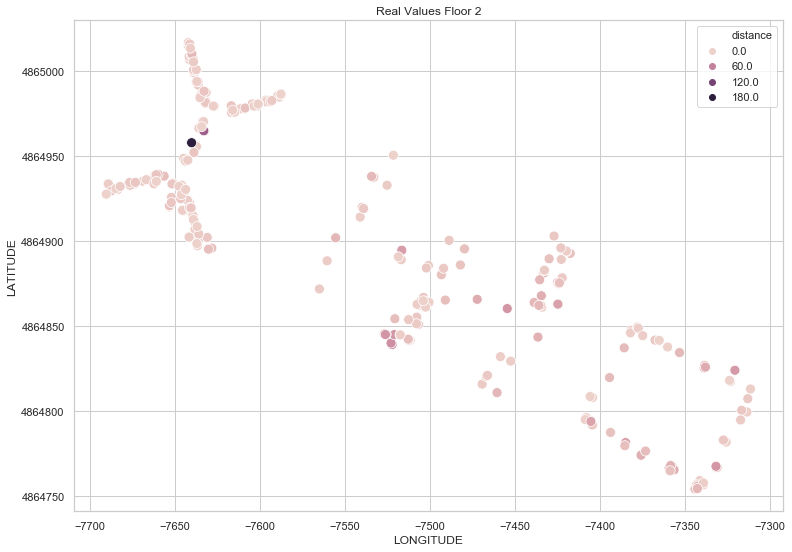

Text(0.5, 1.0, 'Predictions Floor 3')

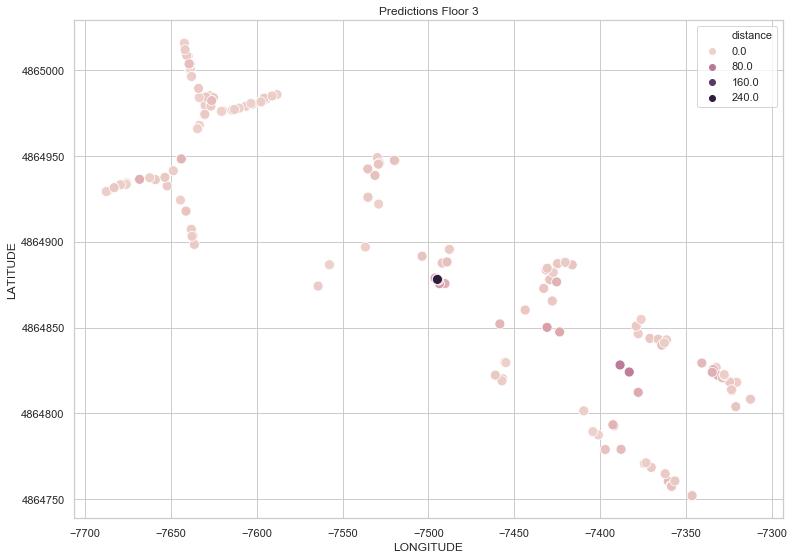

Text(0.5, 1.0, 'Real Values Floor 3')

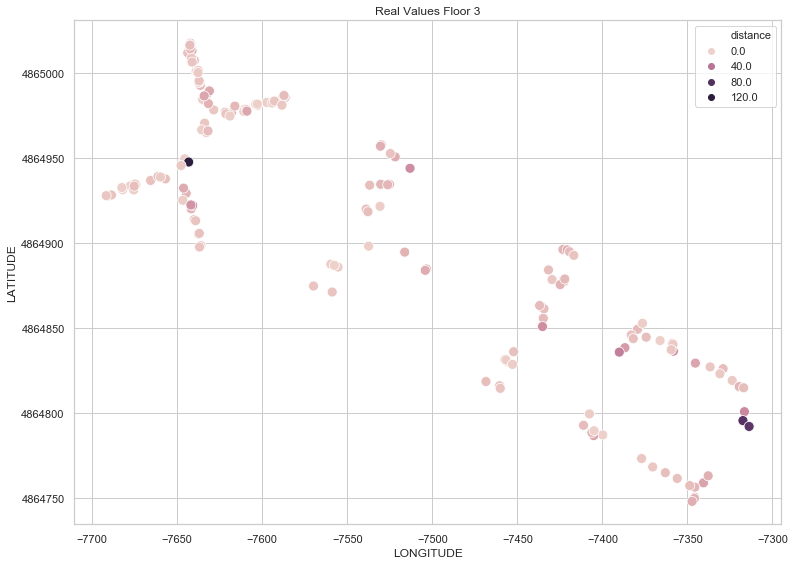

Text(0.5, 1.0, 'Predictions Floor 4')

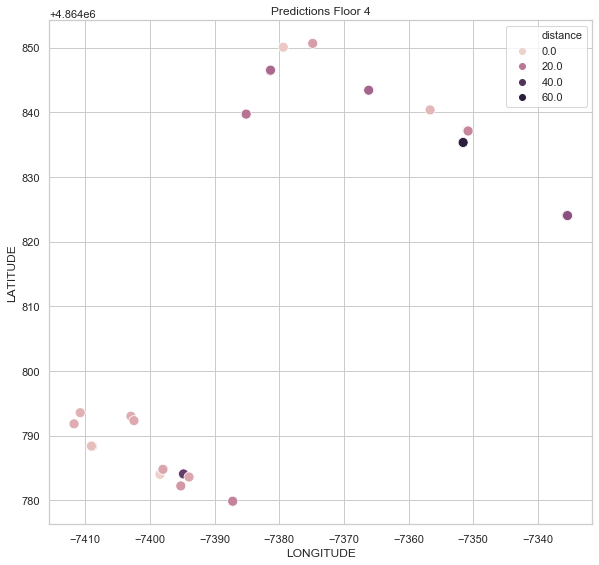

Text(0.5, 1.0, 'Real Values Floor 4')

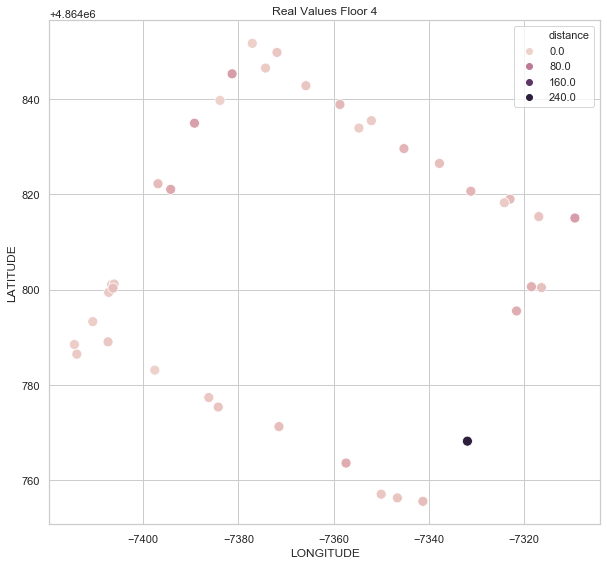

In [9]:

print(f"Mean error in meters {score}")

for floor in sorted(predictions.FLOOR.unique()):
    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        ax=ax,
        s=100,
        data=predictions[predictions["FLOOR"] == int(floor)],
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Predictions Floor {int(floor)}")
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        s=100,
        data=true_values[true_values["FLOOR"] == int(floor)],
        ax=ax,
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Real Values Floor {int(floor)}")
    plt.show()



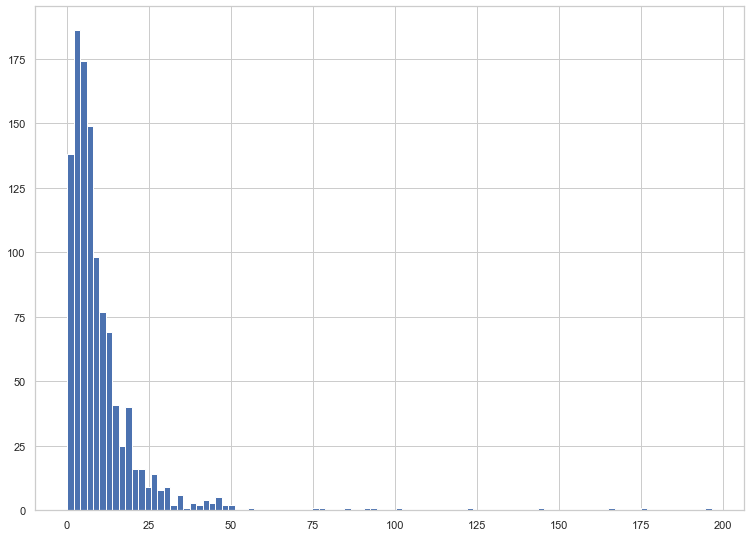

In [10]:

predictions.distance.hist(bins=100)

